# C. Elegans DNA

Import libraries for later use

In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

Read the C.Elegens .csv file. We add our own headers - labels stands for whether there is a splice site or not and the DNA is a string representing the DNA

In [2]:
df = pd.read_csv('exercise_data/C_elegans_acc_seq.csv', header=None, names=['labels', 'DNA'])

### Doing the Test-Train-Split

In [3]:
from sklearn.model_selection import train_test_split

np.random.seed(28)
train, test = train_test_split(df, test_size=0.2)

# Make a copy of the raw dna sequences for later use with Shogun
train_raw = np.array(train)
test_raw = np.array(test)
X_train = train_raw[:,1]
y_train = train_raw[:,0]
X_test = test_raw[:,1]
y_test = test_raw[:,0]

In [4]:
# Check the label proportions are similar. stratify=True for splitting threw a weird exception
print(100*np.sum(df['labels']==1)/df.shape[0])
print(100*np.sum(train['labels']==1)/train.shape[0])
print(100*np.sum(test['labels']==1)/test.shape[0])

9.090909090909092
8.977272727272727
9.545454545454545


### Mapping DNA to a vector

We will map the DNA into a vector, by mapping each Character (A,T,C,G) into a one-hot vector and then concatenating all these vectors together. As we have a string of 82 Characters this gives us a final vector of length 328

In [5]:
import utility
train['DNA'] = train['DNA'].map(utility.map_dna_into_vector)
test['DNA'] = test['DNA'].map(utility.map_dna_into_vector)

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Creating DataFrame for later Evaluation

In [6]:
f1_eval_df = pd.DataFrame(data=[], columns=['Name', 'AUROC_cv', 'f1_cv', 'AUROC_test', 'AUPRC_test', 'f1_test'])
auroc_eval_df = pd.DataFrame(data=[], columns=['Name', 'AUROC_cv', 'f1_cv', 'AUROC_test', 'AUPRC_test', 'f1_test'])

## Models

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
def evaluate_model(model, params, df, train, test, metric, half=0, svc=0):
    # Put Data into a readable Matrix format
    train_data = np.vstack(train['DNA'].values)
    test_data  = np.vstack(test['DNA'].values)
    
    if half:
        if half == 1:
            train_data = train_data[:, :int(train_data.shape[1]/2) - 4]
            test_data = test_data[:, :int(test_data.shape[1]/2) - 4]
        elif half == 2:
            train_data = train_data[:, (int(train_data.shape[1]/2) + 8):]
            test_data = test_data[:, (int(test_data.shape[1]/2) + 8):]
        else:
            raise ValueError('half must take values 0|1|2')
    
    # Create Instance of our Model
    m = model()
    
    # Specify metrics
    scoring = {'roc_auc': 'roc_auc', 'f1': 'f1'}
    
    # Search for the best params in our model and print the best score
    clf = GridSearchCV(m, params, scoring=scoring, refit=metric, cv=5, n_jobs=-1)
    clf.fit(train_data, train['labels'].values)
    print(f"The best score was: {clf.best_score_}")
    
    # Extract cv metric results
    results = clf.cv_results_
    cv_dict = {'AUROC_cv':results['mean_test_roc_auc'][clf.best_index_],
               'f1_cv':results['mean_test_f1'][clf.best_index_]}
    
    # Train our best model on the whole train-dataset
    best_estimator = model(**clf.best_params_)
    best_estimator.fit(train_data, train['labels'].values)
    
    # Evaluate on the Test set
    pred_val = best_estimator.predict(test_data)
    true_val = test['labels'].values
    if svc:
        pred_scores = best_estimator.decision_function(test_data)
    else:
        pred_scores = best_estimator.predict_proba(test_data)[:,1]
        
    auroc_test, auprc_test, f1_test = utility.get_scores(true_val, pred_val, pred_scores)
    test_dict = {'AUROC_test': auroc_test, 
                 'AUPRC_test': auprc_test, 
                 'f1_test': f1_test}
    
    # Append to our Dataframe
    new_row = {'Name': model.__name__ + '_half' + str(half)} if half else {'Name': model.__name__}
    new_row.update(cv_dict)
    new_row.update(test_dict)
    df = df.append(new_row, ignore_index=True)
    return (best_estimator, df)

### Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10, 100],
    'class_weight': [None, 'balanced']
}

In [11]:
lg_best_estimator, f1_eval_df = evaluate_model(LogisticRegression, params, f1_eval_df, train, test, 'f1')
_, auroc_eval_df = evaluate_model(LogisticRegression, params, auroc_eval_df, train, test, 'roc_auc')

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best score was: 0.7817207800759418


C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best score was: 0.9813745242312332


### SVC

In [12]:
from sklearn.svm import SVC

In [13]:
params = {'kernel': ['linear', 'rbf', 'poly'],
          'C': [0.1, 1, 10, 100],
          'class_weight': [None, 'balanced'],
          'gamma': ['auto', 'scale']
         }

In [14]:
svc_best_estimator, f1_eval_df = evaluate_model(SVC, params, f1_eval_df, train, test, 'f1', svc=1)
_, auroc_eval_df = evaluate_model(SVC, params, auroc_eval_df, train, test, 'roc_auc', svc=1)

The best score was: 0.8188472249423642
The best score was: 0.9854422661809914


### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
params = {'n_estimators':[10, 50, 100, 500],
          'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [17]:
rfc_best_estimator, f1_eval_df = evaluate_model(RandomForestClassifier, params, f1_eval_df, train, test, 'f1')
_, auroc_eval_df = evaluate_model(RandomForestClassifier, params, auroc_eval_df, train, test, 'roc_auc')

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.3115968899521531


C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.9814603784217382


###  Gaussian Process Classifer

In [18]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, PairwiseKernel

In [19]:
params = {
    'kernel' : [RBF(), PairwiseKernel()]
}

In [20]:
gpc_best_estimator, f1_eval_df = evaluate_model(GaussianProcessClassifier, params, f1_eval_df, train, test, 'f1')
_, auroc_eval_df = evaluate_model(GaussianProcessClassifier, params, auroc_eval_df, train, test, 'roc_auc')

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.7282852086438152


C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.9757707661004833


## SVM + String kernels (using SHOGUN)

In [21]:
import shogun as sg

features_train = sg.StringCharFeatures(list(X_train), sg.DNA)
labels_train = sg.BinaryLabels(y_train.astype(int))
features_test = sg.StringCharFeatures(list(X_test), sg.DNA)
labels_test = sg.BinaryLabels(y_test.astype(int))

### Weighted Degree Kernel

We perform optimization via grid search

In [22]:
#Root
#param_tree_root = sg.ModelSelectionParameters()

#Parameter C
#C = sg.ModelSelectionParameters("C")
#param_tree_root.append_child(C)
#C.build_values(1, 10, sg.R_LINEAR, 1, 2)
#C.set_values(1,2,3)

#kernel = sg.WeightedDegreeStringKernel(features_train, features_train, kernel_degree)
#svm = sg.LibSVM(C, kernel, labels_train)

#C.print_tree()

In [23]:
C = 2
kernel_degree = 3

kernel = sg.WeightedDegreeStringKernel(features_train, features_train, kernel_degree)
svm = sg.LibSVM(C, kernel, labels_train)

# Cross validation
stratified_split = sg.StratifiedCrossValidationSplitting(labels_train, 5)
metric = sg.F1Measure()
cross = sg.CrossValidation(svm, features_train, labels_train, stratified_split, metric)
# 25 runs and 95% confidence intervals
cross.set_num_runs(25)
cross.set_autolock(False)
result = cross.evaluate()
cv_score = sg.CrossValidationResult.obtain_from_generic(result).get_mean()
print("CV score", metric.get_name(), cv_score)

CV score F1Measure 0.81192444920483


Train on whole train dataset to evaluate test performance

In [24]:
svm.train()
pred = svm.apply(features_test)
pred_val = pred.get_labels()
pred_scores = pred.get_values()
auroc, auprc, f1_test = utility.get_scores(y_test.astype(int), pred_val, pred_scores)
    
# Append to our Dataframe
f1_eval_df = f1_eval_df.append({'Name': 'WDK_' + str(kernel_degree), 'f1_cv':cv_score, 'AUROC_test':auroc, 'AUPRC_test': auprc, 'f1_test':f1_test}, ignore_index=True)

### Fixed Degree String Kernel

In [25]:
C = 2
kernel_degree = 3

kernel = sg.FixedDegreeStringKernel(features_train, features_train, kernel_degree)
svm = sg.LibSVM(C, kernel, labels_train)

# Cross validation
stratified_split = sg.StratifiedCrossValidationSplitting(labels_train, 5)
metric = sg.F1Measure()
cross = sg.CrossValidation(svm, features_train, labels_train, stratified_split, metric)
# 25 runs and 95% confidence intervals
cross.set_num_runs(25)
cross.set_autolock(False)
result = cross.evaluate()
cv_score = sg.CrossValidationResult.obtain_from_generic(result).get_mean()
print("CV score", metric.get_name(), cv_score)

CV score F1Measure 0.786039714568037


Train on whole train dataset to evaluate test performance

In [26]:
svm.train()
pred = svm.apply(features_test)
pred_val = pred.get_labels()
pred_scores = pred.get_values()
auroc, auprc, f1_test = utility.get_scores(y_test.astype(int), pred_val, pred_scores)
    
# Append to our Dataframe
f1_eval_df = f1_eval_df.append({'Name': 'FDK_' + str(kernel_degree), 'f1_cv':cv_score, 'AUROC_test':auroc, 'AUPRC_test': auprc, 'f1_test':f1_test}, ignore_index=True)

### Oligo String Kernel

In [27]:
C = 2
kernel_degree = 3
kernel_width = 10

kernel = sg.OligoStringKernel(features_train, features_train, kernel_degree, kernel_width)
svm = sg.LibSVM(C, kernel, labels_train)

# Cross validation
stratified_split = sg.StratifiedCrossValidationSplitting(labels_train, 5)
metric = sg.F1Measure()
cross = sg.CrossValidation(svm, features_train, labels_train, stratified_split, metric)
# 25 runs and 95% confidence intervals
cross.set_num_runs(1)
cross.set_autolock(False)
result = cross.evaluate()
cv_score = sg.CrossValidationResult.obtain_from_generic(result).get_mean()
print("CV score", metric.get_name(), cv_score)

CV score F1Measure 0.7269862597418701


Train on whole train dataset to evaluate test performance

In [28]:
svm.train()
pred = svm.apply(features_test)
pred_val = pred.get_labels()
pred_scores = pred.get_values()
auroc, auprc, f1_test = utility.get_scores(y_test.astype(int), pred_val, pred_scores)
    
# Append to our Dataframe
f1_eval_df = f1_eval_df.append({'Name': 'OSK_' + str(kernel_degree) + '_' + str(kernel_width),
                                'f1_cv':cv_score, 'AUROC_test':auroc, 'AUPRC_test': auprc, 'f1_test':f1_test}, ignore_index=True)

### Weighted Degree Position String Kernel

In [29]:
C = 2
kernel_degree = 1

kernel = sg.WeightedDegreePositionStringKernel(features_train, features_train, kernel_degree)
svm = sg.LibSVM(C, kernel, labels_train)

# Cross validation
stratified_split = sg.StratifiedCrossValidationSplitting(labels_train, 5)
metric = sg.F1Measure()
cross = sg.CrossValidation(svm, features_train, labels_train, stratified_split, metric)
# 25 runs and 95% confidence intervals
cross.set_num_runs(25)
cross.set_autolock(False)
result = cross.evaluate()
cv_score = sg.CrossValidationResult.obtain_from_generic(result).get_mean()
print("CV score", metric.get_name(), cv_score)

CV score F1Measure 0.7863464885851902


Train on whole train dataset to evaluate test performance

In [30]:
svm.train()
pred = svm.apply(features_test)
pred_val = pred.get_labels()
pred_scores = pred.get_values()
auroc, auprc, f1_test = utility.get_scores(y_test.astype(int), pred_val, pred_scores)
    
# Append to our Dataframe
f1_eval_df = f1_eval_df.append({'Name': 'WDPSK_' + str(kernel_degree), 'f1_cv':cv_score, 'AUROC_test':auroc, 'AUPRC_test': auprc, 'f1_test':f1_test}, ignore_index=True)

### Multiple Kernel Learning

Here we combine the better performing previous kernels mixed via a weighted average

In [31]:
if False:
    C = 1

    #poly_kernel = sg.PolyKernel(dot_features, dot_features, 3, True, 10)
    WD_kernel = sg.WeightedDegreeStringKernel(3)
    #WDP_kernel = sg.WeightedDegreePositionStringKernel()

    combined_kernel = sg.CombinedKernel()
    combined_kernel.append_kernel(WD_kernel)
    #combined_kernel.append_kernel(WDP_kernel)
    combined_kernel.init(features_train, features_train)

    svm = sg.LibSVM(C, combined_kernel, labels_train)

    # Cross validation
    stratified_split = sg.StratifiedCrossValidationSplitting(labels_train, 5)
    metric = sg.F1Measure()
    cross = sg.CrossValidation(svm, features_train, labels_train, stratified_split, metric)
    # 25 runs and 95% confidence intervals
    cross.set_num_runs(25)
    cross.set_autolock(False)
    result = cross.evaluate()
    cv_score = sg.CrossValidationResult.obtain_from_generic(result).get_mean()
    print("CV score", metric.get_name(), cv_score)

Train on whole train dataset to evaluate test performance

In [32]:
if False:
    svm.train()
    pred = svm.apply(features_test)
    pred_val = pred.get_labels()
    pred_scores = pred.get_values()
    auroc, auprc, f1_test = utility.get_scores(y_test.astype(int), pred_val, pred_scores)

    # Append to our Dataframe
    f1_eval_df = f1_eval_df.append({'Name': 'MKL', 'f1_cv':cv_score, 'AUROC_test':auroc, 'AUPRC_test': auprc, 'f1_test':f1_test}, ignore_index=True)

### DL Model

In [33]:
import tensorflow as tf
from tensorflow.python.keras.layers import BatchNormalization,Conv1D,Input,Add,Dense,Flatten
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizers import Adam

def add_RB(x):
    xout=BatchNormalization()(x)
    xout=Conv1D(filters=32,kernel_size=11,dilation_rate=1,padding='same',activation='relu')(x)
    xout=BatchNormalization()(xout)
    xout=Conv1D(filters=32,kernel_size=11,dilation_rate=1,padding='same',activation='relu')(xout)
    return xout

In [34]:
tf.reset_default_graph()
x=Input(shape=[328,1])

x1=Conv1D(filters=32,kernel_size=1,dilation_rate=1,padding='same',activation='relu')(x)

xrb=add_RB(x1)

x2=Conv1D(filters=32,kernel_size=1,dilation_rate=1,padding='same',activation='relu')(xrb)
x3=Conv1D(filters=32,kernel_size=1,dilation_rate=1,padding='same',activation='relu')(x1)

xout=Conv1D(filters=1,kernel_size=1,dilation_rate=1,padding='same',activation='relu')(Add()([x2,x3]))
xout=Flatten()(xout)
xout=Dense(units=1,activation='sigmoid')(xout)

model=Model(x,xout)
model.compile(optimizer=Adam(),loss='binary_crossentropy')
class_wt={0:1,1:15}

train_data = np.vstack(train['DNA'].values)[:,:,None]
test_data  = np.vstack(test['DNA'].values)[:,:,None]

train_val=train['labels'].values
train_val[train_val==-1]=0
model.fit(x=train_data,y=train_val,batch_size=64,epochs=20,class_weight=class_wt)

Epoch 1/20
1760/1760 [==============================] - 14s 8ms/step - loss: 1.3011
Epoch 2/20
1760/1760 [==============================] - 1s 309us/step - loss: 0.7185
Epoch 3/20
1760/1760 [==============================] - 1s 330us/step - loss: 0.4260
Epoch 4/20
1760/1760 [==============================] - 1s 313us/step - loss: 0.2580
Epoch 5/20
1760/1760 [==============================] - 1s 311us/step - loss: 0.1613
Epoch 6/20
1760/1760 [==============================] - 0s 279us/step - loss: 0.1122
Epoch 7/20
1760/1760 [==============================] - 1s 394us/step - loss: 0.0759
Epoch 8/20
1760/1760 [==============================] - 1s 379us/step - loss: 0.0619
Epoch 9/20
1760/1760 [==============================] - 1s 346us/step - loss: 0.0563
Epoch 10/20
1760/1760 [==============================] - 1s 414us/step - loss: 0.0458
Epoch 11/20
1760/1760 [==============================] - 1s 358us/step - loss: 0.0344
Epoch 12/20
1760/1760 [==============================] - 1s 323u

In [35]:
pred_scores=model.predict(test_data)
pred_val=(pred_scores>0.5).astype(np.int)
true_val=test['labels']
true_val[true_val==-1]=0
dl_mtr=utility.get_scores(true_val,pred_val,pred_scores)

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj

In [36]:
f1_eval_df = f1_eval_df.append({'Name': 'DL Model', 'AUROC_test':dl_mtr[0], 'AUPRC_test': dl_mtr[1], 'f1_test':dl_mtr[2]}, ignore_index=True)

### SVC half string

In this section we only use the first or second half of the dna sequences in order to assess the influence of each substring in the accuracy of predictions.

First substring:

In [37]:
params = {'kernel': ['linear', 'rbf', 'poly'],
          'C': [0.1, 1, 10, 100],
          'class_weight': [None, 'balanced'],
          'gamma': ['auto', 'scale']
         }

In [38]:
svc_best_estimator_half, f1_eval_df = evaluate_model(SVC, params, f1_eval_df, train, test, 'f1', half=1, svc=1)
_, auroc_eval_df = evaluate_model(SVC, params, auroc_eval_df, train, test, 'roc_auc', half=1, svc=1)

C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.7901082530012139


C:\Users\juaaa\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best score was: 0.9783415356339815


Second substring:

In [39]:
params = {'kernel': ['linear', 'rbf', 'poly'],
          'C': [0.1, 1, 10, 100],
          'class_weight': [None, 'balanced'],
          'gamma': ['auto', 'scale']
         }

In [40]:
svc_best_estimator_half, f1_eval_df = evaluate_model(SVC, params, f1_eval_df, train, test, 'f1', half=2, svc=1)
_, auroc_eval_df = evaluate_model(SVC, params, auroc_eval_df, train, test, 'roc_auc', half=2, svc=1)

The best score was: 0.23925972623629105
The best score was: 0.6995015124893226


## Evaluation

In [41]:
f1_eval_df

,Name,AUROC_cv,f1_cv,AUROC_test,AUPRC_test,f1_test
0,LogisticRegression,0.981354,0.781721,0.979361,0.868798,0.771084
1,SVC,0.984314,0.818847,0.988035,0.917494,0.850575
2,RandomForestClassifier,0.973682,0.311597,0.964076,0.861099,0.285714
3,GaussianProcessClassifier,0.975771,0.728285,0.976071,0.843303,0.761905
4,WDK_3,NaN,0.811924,0.987976,0.917648,0.810811
5,FDK_3,NaN,0.786040,0.987497,0.900104,0.763158
6,OSK_3_10,NaN,0.726986,0.980498,0.877023,0.739726
7,WDPSK_1,NaN,0.786346,0.991804,0.936978,0.867470
8,DL Model,NaN,NaN,0.982352,0.878822,0.795181
9,SVC_half1,0.977560,0.790108,0.986540,0.900741,0.808511


We cross validated with respect to f1 score since auprc was not available in some of the models considered. We also ran a grid search optimizing auroc in order to verify that the difference in performance was not significant.

In [42]:
auroc_eval_df

,Name,AUROC_cv,f1_cv,AUROC_test,AUPRC_test,f1_test
0,LogisticRegression,0.981375,0.781721,0.979361,0.868798,0.771084
1,SVC,0.985442,0.709872,0.987377,0.919913,0.722222
2,RandomForestClassifier,0.981460,0.219902,0.979481,0.882311,0.415094
3,GaussianProcessClassifier,0.975771,0.728285,0.976071,0.843303,0.761905
4,SVC_half1,0.978342,0.663496,0.985284,0.898132,0.650000
5,SVC_half2,0.699502,0.231438,0.702860,0.153037,0.201681


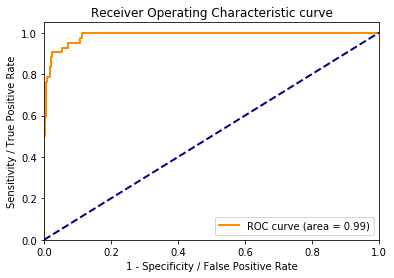

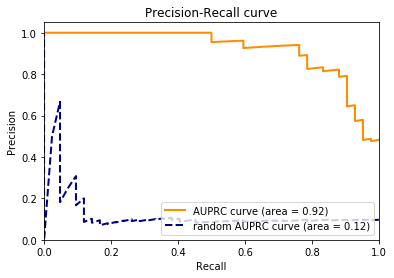

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

best_estimator = svc_best_estimator
predicted_values = best_estimator.predict(np.vstack(test['DNA'].values))
predicted_scores = best_estimator.decision_function(np.vstack(test['DNA'].values))
true_values = test['labels']

# compute ROC curve
fpr, tpr, thresholds_roc = roc_curve(true_values, predicted_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds_prc = precision_recall_curve(true_values, predicted_scores)

# compute precision-recall curve
auprc = auc(recall, precision)
precision_random, recall_random, thresholds_random = precision_recall_curve(true_values, np.random.rand(len(true_values)))
auprc_random = auc(recall_random, precision_random)
other_scores_validation = [roc_auc, auprc, auprc_random]

# plot curves
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity / False Positive Rate')
plt.ylabel('Sensitivity / True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
#plt.savefig('./models/' + experiment_id + '/' + model_name + '_roc_curve_validation.png')

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
                     lw=lw, label='AUPRC curve (area = %0.2f)' % auprc)
plt.plot(recall_random, precision_random, color='navy', linestyle='--',
                     lw=lw, label='random AUPRC curve (area = %0.2f)' % auprc_random)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")



## Conclusion

- Kernelized SVM and DL works the best, but not much better than other simpler models such as logistic regression.
- String kernels didn't improve over polynomial kernel.
- First half of the dna sequences holds most of the relevant information for prediction